In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [2]:
df = pd.read_csv("/Users/erion/Desktop/MSCF2/ADA/Capstone-Project/data/processed/modeling_dataset.csv", index_col=0, parse_dates=True)

print("Dataset loaded!")
print(df.shape)
print(df.head())

Dataset loaded!
(5469, 43)
                gold    eurusd  treasury_10y       spy       vix       dxy  \
Date                                                                         
2004-01-13 -0.006099  0.003529         4.028 -0.005830  0.072533 -0.000468   
2004-01-14 -0.004720 -0.010551         3.986  0.008351 -0.071508  0.006081   
2004-01-15 -0.031539 -0.003957         3.971  0.002468 -0.071045  0.006161   
2004-01-16 -0.004163 -0.016105         4.014  0.003955 -0.035990  0.013517   
2004-01-19  0.000000 -0.003546         4.014  0.000000  0.000000 -0.000798   

                 oil    target  gold_lag1  gold_lag2  ...  vix_lag3  dxy_lag1  \
Date                                                  ...                       
2004-01-13 -0.008353 -0.004720  -0.000235   0.005660  ...  0.007097  0.005170   
2004-01-14  0.002033 -0.031539  -0.006099  -0.000235  ...  0.073030 -0.000468   
2004-01-15 -0.030725 -0.004163  -0.004720  -0.006099  ...  0.004179  0.006081   
2004-01-16  0.048744 

In [3]:
# Walk-forward validation from 2016 to 2024
years = list(range(2016, 2025))
results = []
print("Years to evaluate:", years)

Years to evaluate: [2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]


In [4]:
def evaluate_forecast(y_true, y_pred):
    """
    Computes RMSE, MAE, and directional accuracy.
    Returns a dictionary.
    """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    dir_acc = (np.sign(y_true) == np.sign(y_pred)).mean() * 100
    return {
        "RMSE": rmse,
        "MAE": mae,
        "DirAcc": dir_acc
    }

In [5]:
def predict_naive(X_test):
    # yesterday's return
    return X_test['gold_lag1']

def predict_sma(y_train, length, test_index):
    sma_value = y_train.rolling(length).mean().iloc[-1]
    return pd.Series([sma_value] * len(test_index), index=test_index)

In [6]:
def train_rf(X_train, y_train):
    rf = RandomForestRegressor(
        n_estimators=300,
        max_depth=6,
        random_state=42
    )
    rf.fit(X_train, y_train)
    return rf

def train_xgb(X_train, y_train):
    xgb = XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:squarederror',
        random_state=42
    )
    xgb.fit(X_train, y_train)
    return xgb

In [7]:
def build_mlp(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


def build_lstm(input_dim):
    model = Sequential([
        LSTM(32, return_sequences=False, input_shape=(1, input_dim)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


def build_gru(input_dim):
    model = Sequential([
        GRU(32, return_sequences=False, input_shape=(1, input_dim)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [8]:
results = []

years = list(range(2016, 2025))
print("Running walk-forward validation for years:", years)

for year in years:
    print("\n" + "="*80)
    print(f" YEAR {year} — TRAINING UP TO {year-1}, TESTING {year}")
    print("="*80)

    # 1. Define train/test splits
    train = df[df.index < f"{year}-01-01"].copy()
    test = df[(df.index >= f"{year}-01-01") & (df.index <= f"{year}-12-31")].copy()

    if len(test) == 0:
        print(f"No data for year {year}, skipping...")
        continue

    X_train = train.drop(columns=["target"])
    y_train = train["target"]

    X_test = test.drop(columns=["target"])
    y_test = test["target"]

    # --- BASELINES -------------------------------------------------------------------------

    # Naive
    pred_naive = predict_naive(X_test)
    metrics_naive = evaluate_forecast(y_test, pred_naive)

    # SMA(20)
    pred_sma20 = predict_sma(y_train, 20, X_test.index)
    metrics_sma20 = evaluate_forecast(y_test, pred_sma20)

    # --- MACHINE LEARNING ------------------------------------------------------------------

    # Random Forest (scaled)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    rf = train_rf(X_train_scaled, y_train)
    pred_rf = rf.predict(X_test_scaled)
    metrics_rf = evaluate_forecast(y_test, pred_rf)

    # XGBoost (no scaling)
    xgb = train_xgb(X_train, y_train)
    pred_xgb = xgb.predict(X_test)
    metrics_xgb = evaluate_forecast(y_test, pred_xgb)

    # --- DEEP LEARNING ---------------------------------------------------------------------

    # MLP
    mlp = build_mlp(X_train.shape[1])
    mlp.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)
    pred_mlp = mlp.predict(X_test).flatten()
    metrics_mlp = evaluate_forecast(y_test, pred_mlp)

    # LSTM (reshape to (samples, 1, features))
    X_train_lstm = np.expand_dims(X_train, axis=1)
    X_test_lstm  = np.expand_dims(X_test, axis=1)

    lstm = build_lstm(X_train.shape[1])
    lstm.fit(X_train_lstm, y_train, epochs=20, batch_size=32, verbose=0)
    pred_lstm = lstm.predict(X_test_lstm).flatten()
    metrics_lstm = evaluate_forecast(y_test, pred_lstm)

    # GRU
    gru = build_gru(X_train.shape[1])
    gru.fit(X_train_lstm, y_train, epochs=20, batch_size=32, verbose=0)
    pred_gru = gru.predict(X_test_lstm).flatten()
    metrics_gru = evaluate_forecast(y_test, pred_gru)

    # --- STORE ALL RESULTS ---------------------------------------------------------------
    results.append({
        "Year": year,

        "Naive_RMSE": metrics_naive["RMSE"],
        "Naive_MAE":  metrics_naive["MAE"],
        "Naive_DA":   metrics_naive["DirAcc"],

        "SMA20_RMSE": metrics_sma20["RMSE"],
        "SMA20_MAE":  metrics_sma20["MAE"],
        "SMA20_DA":   metrics_sma20["DirAcc"],

        "RF_RMSE": metrics_rf["RMSE"],
        "RF_MAE":  metrics_rf["MAE"],
        "RF_DA":   metrics_rf["DirAcc"],

        "XGB_RMSE": metrics_xgb["RMSE"],
        "XGB_MAE":  metrics_xgb["MAE"],
        "XGB_DA":   metrics_xgb["DirAcc"],

        "MLP_RMSE": metrics_mlp["RMSE"],
        "MLP_MAE":  metrics_mlp["MAE"],
        "MLP_DA":   metrics_mlp["DirAcc"],

        "LSTM_RMSE": metrics_lstm["RMSE"],
        "LSTM_MAE":  metrics_lstm["MAE"],
        "LSTM_DA":   metrics_lstm["DirAcc"],

        "GRU_RMSE": metrics_gru["RMSE"],
        "GRU_MAE":  metrics_gru["MAE"],
        "GRU_DA":   metrics_gru["DirAcc"]
    })

print("\nWalk-forward validation completed for all years!")

Running walk-forward validation for years: [2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]

 YEAR 2016 — TRAINING UP TO 2015, TESTING 2016
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

 YEAR 2017 — TRAINING UP TO 2016, TESTING 2017
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

 YEAR 2018 — TRAINING UP TO 2017, TESTING 2018
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

 YEAR 2019 — TRAINING UP TO 2018, TESTING 2019
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

 YEAR 2020 — TRAINING UP TO 2019, TESTING 2020
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

 YEAR 2021 — TRAINING UP TO 2020, TESTING 2021
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
9/9 ━━

In [9]:
results_df = pd.DataFrame(results)
results_df

,Year,Naive_RMSE,Naive_MAE,Naive_DA,SMA20_RMSE,SMA20_MAE,SMA20_DA,RF_RMSE,RF_MAE,RF_DA,...,XGB_DA,MLP_RMSE,MLP_MAE,MLP_DA,LSTM_RMSE,LSTM_MAE,LSTM_DA,GRU_RMSE,GRU_MAE,GRU_DA
0,2016,0.013904,0.010316,45.977011,0.010116,0.007015,49.042146,0.009988,0.006987,45.210728,...,48.275862,0.013847,0.010911,45.977011,0.010385,0.007802,46.743295,0.010592,0.007548,46.360153
1,2017,0.009116,0.007257,44.230769,0.006594,0.005128,43.461538,0.006425,0.004925,52.307692,...,48.461538,0.008168,0.006380,51.923077,0.006442,0.004993,50.000000,0.007068,0.005533,51.538462
2,2018,0.008669,0.006751,45.593870,0.006619,0.004802,45.977011,0.006491,0.004667,46.743295,...,47.892720,0.024861,0.023595,45.977011,0.007553,0.005832,45.977011,0.011058,0.009379,48.659004
3,2019,0.009857,0.007423,48.659004,0.007170,0.005124,52.490421,0.007140,0.005061,52.107280,...,50.191571,0.011275,0.009075,52.490421,0.007471,0.005413,50.957854,0.007666,0.005607,45.593870
4,2020,0.018612,0.013098,43.511450,0.013261,0.008990,56.488550,0.013767,0.009377,55.725191,...,50.381679,0.075128,0.066611,40.076336,0.013861,0.009617,46.946565,0.017555,0.012148,53.816794
5,2021,0.013637,0.010152,42.528736,0.009417,0.006540,51.724138,0.009286,0.006420,51.724138,...,49.808429,0.011531,0.008783,46.743295,0.009558,0.007013,45.977011,0.010568,0.008327,45.210728
6,2022,0.013828,0.010979,41.538462,0.009546,0.007183,50.769231,0.009533,0.007160,50.384615,...,50.384615,0.010510,0.007995,47.307692,0.009821,0.007591,50.000000,0.009949,0.007559,45.769231
7,2023,0.011790,0.008958,43.076923,0.008222,0.006081,48.846154,0.008166,0.005926,49.230769,...,49.615385,0.011210,0.008610,50.384615,0.008466,0.006328,49.230769,0.008772,0.006656,48.846154
8,2024,0.012969,0.010121,49.615385,0.009257,0.006988,55.384615,0.009285,0.007035,53.846154,...,49.230769,0.011894,0.009291,48.076923,0.009779,0.007382,55.384615,0.010169,0.007959,43.461538


In [10]:
results_df.to_csv("/Users/erion/Desktop/MSCF2/ADA/Capstone-Project/results/metrics/walk_forward_results.csv", index=False)
print("Saved to results/metrics/walk_forward_results.csv")

Saved to results/metrics/walk_forward_results.csv


In [11]:
summary_df = results_df.mean(numeric_only=True).to_frame(name="Average")
summary_df

,Average
Year,2020.000000
Naive_RMSE,0.012487
Naive_MAE,0.009451
Naive_DA,44.970179
SMA20_RMSE,0.008912
SMA20_MAE,0.006428
SMA20_DA,50.464867
RF_RMSE,0.008898
RF_MAE,0.006395
RF_DA,50.808874


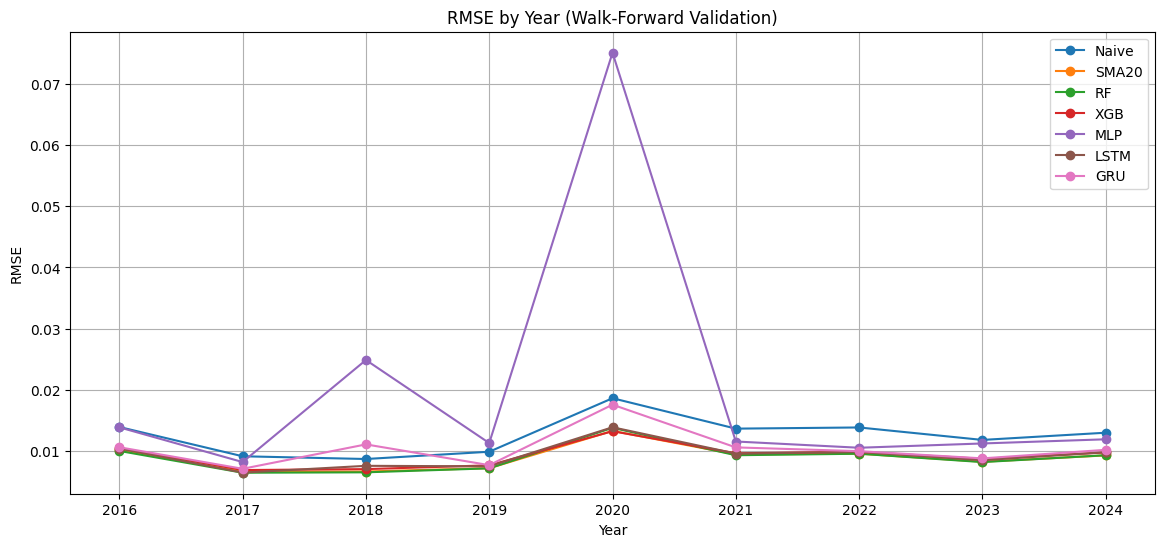

In [12]:
plt.figure(figsize=(14,6))

models = ["Naive", "SMA20", "RF", "XGB", "MLP", "LSTM", "GRU"]

for model in models:
    plt.plot(results_df["Year"], results_df[f"{model}_RMSE"], marker="o", label=model)

plt.title("RMSE by Year (Walk-Forward Validation)")
plt.xlabel("Year")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True)
plt.show()

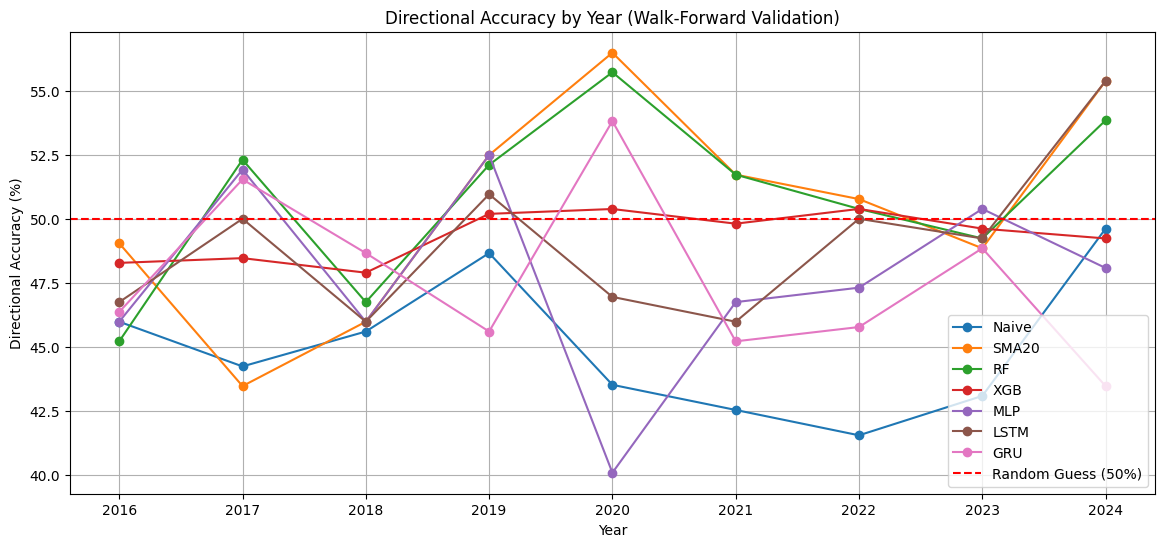

In [13]:
plt.figure(figsize=(14,6))

for model in models:
    plt.plot(results_df["Year"], results_df[f"{model}_DA"], marker="o", label=model)

plt.title("Directional Accuracy by Year (Walk-Forward Validation)")
plt.xlabel("Year")
plt.ylabel("Directional Accuracy (%)")
plt.axhline(50, color='red', linestyle='--', label='Random Guess (50%)')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
best_models = []

for i, row in results_df.iterrows():
    year = row["Year"]

    # compute which model has lowest RMSE
    rmse_cols = {m: row[f"{m}_RMSE"] for m in models}
    best_rmse_model = min(rmse_cols, key=rmse_cols.get)
    
    # compute which model has highest directional accuracy
    da_cols = {m: row[f"{m}_DA"] for m in models}
    best_da_model = max(da_cols, key=da_cols.get)

    best_models.append({
        "Year": year,
        "Best_RMSE_Model": best_rmse_model,
        "Best_RMSE_Value": rmse_cols[best_rmse_model],
        "Best_DA_Model": best_da_model,
        "Best_DA_Value": da_cols[best_da_model]
    })

best_models_df = pd.DataFrame(best_models)
best_models_df

,Year,Best_RMSE_Model,Best_RMSE_Value,Best_DA_Model,Best_DA_Value
0,2016.0,RF,0.009988,SMA20,49.042146
1,2017.0,RF,0.006425,RF,52.307692
2,2018.0,RF,0.006491,GRU,48.659004
3,2019.0,RF,0.007140,SMA20,52.490421
4,2020.0,XGB,0.013220,SMA20,56.488550
5,2021.0,RF,0.009286,SMA20,51.724138
6,2022.0,RF,0.009533,SMA20,50.769231
7,2023.0,RF,0.008166,MLP,50.384615
8,2024.0,SMA20,0.009257,SMA20,55.384615


In [15]:
avg_scores = results_df.mean(numeric_only=True)

# Best (lowest) RMSE model on average
rmse_avgs = {m: avg_scores[f"{m}_RMSE"] for m in models}
best_rmse_overall = min(rmse_avgs, key=rmse_avgs.get)

# Best (highest) Directional Accuracy
da_avgs = {m: avg_scores[f"{m}_DA"] for m in models}
best_da_overall = max(da_avgs, key=da_avgs.get)

print("Best model by RMSE:", best_rmse_overall, rmse_avgs[best_rmse_overall])
print("Best model by Directional Accuracy:", best_da_overall, da_avgs[best_da_overall])

Best model by RMSE: RF 0.00889795170830638
Best model by Directional Accuracy: RF 50.808873580216925
